# Project 1- Mislabeing in training data

This project is set up to investigate the effect of having a certain percentage of mislabel in the training data. The investigation will more specifically investigate the effects on Linear discriminate analysis (LDA), k-Nearest-Neighbours (kNN), and Random forest (RF). These algorithms were chosen in order to investigate algorithms which operate under *Global* and *Local* rules. *Global* rules uses all of the data to determine the decision boundary which usually results in simple decision boundary (i.e LDA with linear boundaries). *Local rules* determines the decision boundary based on a local neighbourhood which results in more complex decision boundary (kNN and RF). ML algorithms operating under *local rules* are also more prone to higher variance in estimation and is therefore hypothesized to be more sensitive to mislabel.
<br /> 


## Import necessary libaries and generate the data

In [1]:
from matplotlib import pyplot as plt




#Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

#Utilities
import numpy as np
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import random



Random_state = 2019
random.seed(Random_state)
np.random.RandomState(seed=Random_state)


#Generate the data to perform the experiment on
X, y = make_blobs(n_samples=[100,100,100], centers=[[-5,0],[5,0],[0,5]],
                  cluster_std= [1,1,1],n_features=2, random_state=Random_state)


#Plot the generated data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Generated data')
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=Random_state) 

<Figure size 640x480 with 1 Axes>

## Create classifier objects and simulations types

In [2]:
Classifiers = (
                ('LDA', LinearDiscriminantAnalysis()), 
                ( 'RF', RandomForestClassifier(n_estimators=10)),
                ('KNN', KNeighborsClassifier(n_neighbors=10)),
                ('KNN where k=40',KNeighborsClassifier(n_neighbors=40)),
                #, 'KNN_Bootstrap': BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10),n_estimators = 1000
                #                                    ,bootstrap_features=True)
                
                )

Simulations = [
                'uniform',
                'NeighbourHood',
              ]

## Creating the Mislabeling function

- **Uniform:** Select a certain percentage of the training data to mislabel at uniform. 
- **Neighbourhood:** Start with selecting a random point. Each percentage of mislabel will mislabel the points closest to the originally selected point

In [3]:
def missLabel(trainData, train_labels, typeOfMislabel, amountOfMisslabel, randomSample):
    originalLabels = []
    chosenMissLabels = []
    train_labels_copy = train_labels.copy() 
    
    #Misslabel a sample to any other class at random 
    if(typeOfMislabel == 'uniform'):
        indexMissLabels = np.random.choice(len(train_labels_copy), amountOfMisslabel, replace=False)
        for i in range(len(indexMissLabels)):  #Loop through all samples that will get mislabled
            classes = [0,1,2]                 
            classes.remove(train_labels_copy[indexMissLabels[i]])
            missLabel = np.random.choice(classes, 1)
            train_labels_copy[indexMissLabels[i]]= missLabel[0]


    #Choose a random point, and start misslabeling all its neighbours, Misslabel randomly any other class than its original
    elif(typeOfMislabel == 'NeighbourHood'):
        clf = KNeighborsClassifier()
        clf.fit(trainData,train_labels)
        indexMissLabels = clf.kneighbors(X=randomSample, n_neighbors=amountOfMisslabel, return_distance=False)[0]
        for i in range(len(indexMissLabels)): #Loop through all samples that will get mislabled
            classes = [0,1,2]
            classes.remove(train_labels_copy[indexMissLabels[i]])
            missLabel = np.random.choice(classes, 1)
            train_labels_copy[indexMissLabels[i]]= missLabel[0]


    return train_labels_copy;


## The experiment

The independent variable will be the amount of 

In [4]:
def runSimulation(typeOfMissLabeling,X_train,y_train,randomSample,X_test,y_test,chosenClf):
    stepPercentage = 100
    y_train_copy = y_train.copy()
    amountOfMissLabel = []
    PerformanceAccuracy = []
    #Run simulation where each iteration will be the amount of Misslabel
    for i in range(1,stepPercentage):    
        y_train_misslabel = missLabel(X_train, y_train_copy,typeOfMissLabeling, int(len(y_train)*(i/stepPercentage)),randomSample)
        chosenClf.fit(X_train,y_train_misslabel)
        PerformanceAccuracy.append(chosenClf.score(X_test, y_test))
        amountOfMissLabel.append(int((i/stepPercentage)*100))
    return amountOfMissLabel, PerformanceAccuracy


## Main code


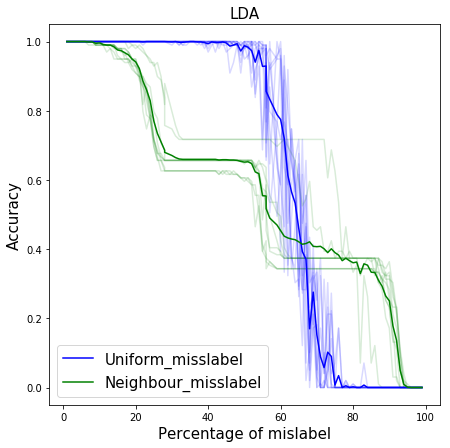

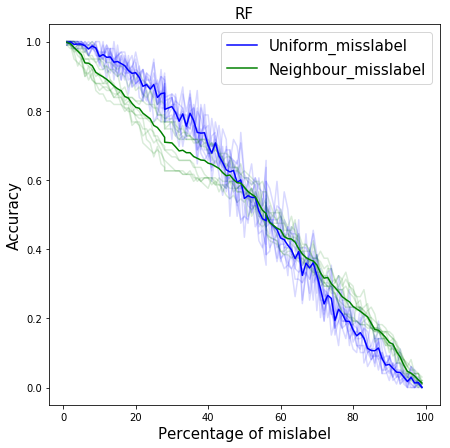

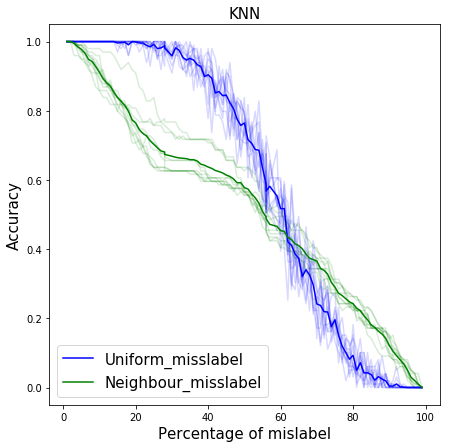

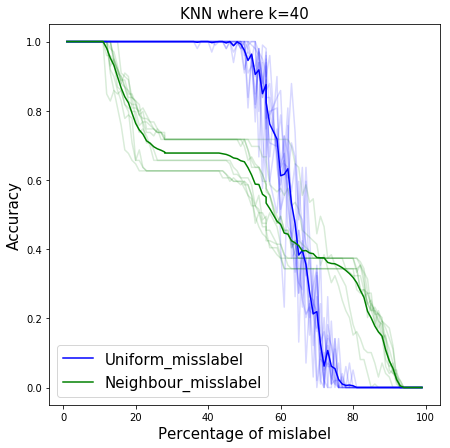

In [5]:

#Run the experiment on the generated data for each classifier
for name, clf in Classifiers:
    mean_Uniform_misslabel = []
    mean_neighbour_misslabel = []
    for i in range(10):    #Run experiment 10 times on each classifier and then average the accuracy results
        plt.figure(1,figsize=(7,7))
        plt.title(name, fontsize=15)
        plt.xlabel('Percentage of mislabel', size = 15)
        plt.ylabel('Accuracy', size= 15)
    
        #Uniform
        xValuesPlot, YValuesPlot = runSimulation('uniform',X_train, y_train, X_train[np.random.choice(len(y_train),1)]  
                                             , X_test, y_test,clf)
        plt.plot(xValuesPlot,YValuesPlot, label='Uniform misslabel', c='b', alpha=0.15)
        
        mean_Uniform_misslabel.append(np.array(YValuesPlot))
        
        #Neighbourhood
        xValuesPlot, YValuesPlot = runSimulation('NeighbourHood',X_train, y_train, X_train[np.random.choice(len(y_train),1)]  
                                             , X_test, y_test,clf)
        
        mean_neighbour_misslabel.append(np.array(YValuesPlot))
        
        plt.plot(xValuesPlot,YValuesPlot, c='g', alpha=0.15)
        
                        
    Uniform_misslabel, = plt.plot(xValuesPlot,np.mean(mean_Uniform_misslabel, axis=0), label='Unifrom misslabel', alpha=1,c ='b')
    neighbour_misslabel, = plt.plot(xValuesPlot,np.mean(mean_neighbour_misslabel, axis=0), label='yo', alpha=1,c ='g')
    plt.legend([Uniform_misslabel,neighbour_misslabel], ['Uniform_misslabel','Neighbour_misslabel'],prop={'size': 15})
    plt.show()


## Plotting decision boundary when mislabeling is 60%

Automatically created module for IPython interactive environment
{0, 1, 2}
{0, 1, 2}


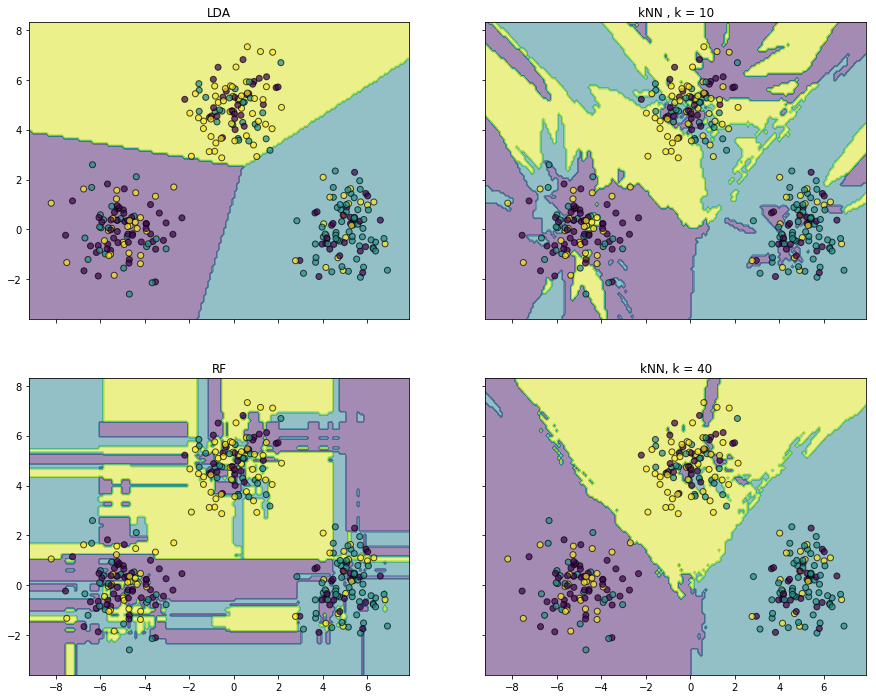

In [6]:
print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Loading some example data
X, y = make_blobs(n_samples=[100,100,100], centers=[[-5,0],[5,0],[0,5]],
                  cluster_std= [1,1,1],n_features=2, random_state=Random_state)

print(set(y))
#Mislabel
y = missLabel(X, y,'uniform', int(len(y)*(50/100)),X[np.random.choice(len(y),1)])

print(set(y))
# Training classifiers
clf1 = LinearDiscriminantAnalysis()
clf2 = KNeighborsClassifier(n_neighbors=10)
clf3 = RandomForestClassifier(n_estimators = 10)
clf4 = KNeighborsClassifier(n_neighbors=40)


clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
clf4.fit(X, y)



x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axesArr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 12))

for idx, clf, graphTitle in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        ['LDA', 'kNN , k = 10',
                         'RF', 'kNN, k = 40']):

    decisionBoundary = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    axesArr[idx[0], idx[1]].contourf(xx, yy, decisionBoundary, alpha=0.5)
    axesArr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  edgecolor='k',alpha=0.7)
    axesArr[idx[0], idx[1]].set_title(graphTitle)

plt.show()

## Conclusions

- LDA operates under *global rules* and is more robust to mislableing 
- RF and kNN operates under *local rules* is more sensitive to mislabeling
- kNN can be modified to act more *globally* by increasing the value of *k*